In [1]:
import os

import numpy as np
import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils import data
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchmetrics.clustering import CompletenessScore
from torchmetrics import Accuracy
import wandb
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
import hydra
from omegaconf import DictConfig, OmegaConf
import lightning as L

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

from my_lit_model import LitMyModuleManual
from my_dataset import get_dataset
from helpers.transformer import transform_train, transform_test, transform_target

/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-13 14:20:48,460	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
trainer = L.Trainer(devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [4]:
with initialize(version_base=None, config_path="conf"):
    conf = compose(config_name="config_our_reg.yaml", overrides=["data=cifar10n", "root=/scratch/tri/shahana_outlier"])

print(OmegaConf.to_yaml(conf))

data:
  'N': 47500
  M: 3
  K: 10
  dataset: cifar10n
train:
  lr: 0.001
  batch_size: 512
  lam1: 0.01
  lam2: 0.01
  num_epochs: 200
  name: reg_version
tags:
- our_reg
root: /scratch/tri/shahana_outlier
debug: false
with_ray: false



/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_our_reg.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [6]:
best_model_path = '/scratch/tri/shahana_outlier/lightning_saved_models/divine-bush-1156/syn-epoch=168-global_step=0.ckpt'
model = LitMyModuleManual.load_from_checkpoint(best_model_path, N=47500, M=3, K=10, lr=1, 
                                         lam1=1e-2, lam2=1e-2, conf=conf)

In [5]:
data_module = get_dataset(conf)
data_module.setup('pred')
# train_set = next(iter(data_module.train_dataloader()))

/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done SETTING data module for CIFAR10-N!


In [10]:
tmp = DataLoader(data_module.train_set, shuffle=False, batch_size=len(data_module.train_set))
train_set = next(iter(tmp))

In [11]:
train_set[0].shape

torch.Size([47500, 3, 32, 32])

In [12]:
E = model.model.get_e()
E.shape

torch.Size([47500, 3, 10])

In [13]:
err = (E**2).sum((1, 2)).detach().cpu().numpy()

In [14]:
inds = np.argsort(err)

In [15]:
err[inds[:10]], err[inds[-10:]], 

(array([0.00386979, 0.00391402, 0.00395164, 0.00395221, 0.0039682 ,
        0.00397446, 0.00398727, 0.00399429, 0.00399638, 0.00400206],
       dtype=float32),
 array([0.17857955, 0.17897749, 0.17929387, 0.17931718, 0.17956237,
        0.17981267, 0.17982817, 0.17988539, 0.18129951, 0.18459842],
       dtype=float32))

In [16]:
# v, inds = torch.topk(err, 512)
# inds = inds.detach().cpu().numpy()

In [17]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

In [18]:
to_image = ToPILImage()

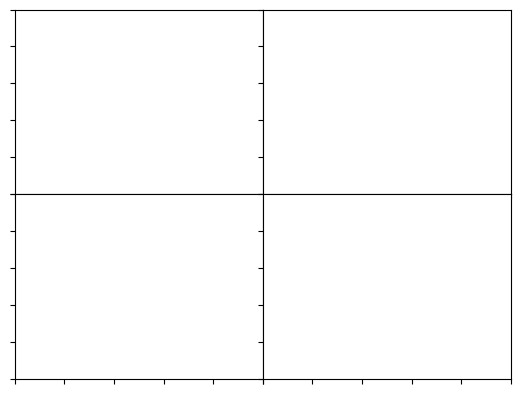

In [25]:

ax = [plt.subplot(2,2,i+1) for i in range(4)]

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

In [82]:
big_image_row1 = torch.concat((train_set[0][0], train_set[0][1]), axis=1)
big_image_row2 = torch.concat((train_set[0][2], train_set[0][3]), axis=1)
big_image = torch.concat((big_image_row1, big_image_row2), axis=2)

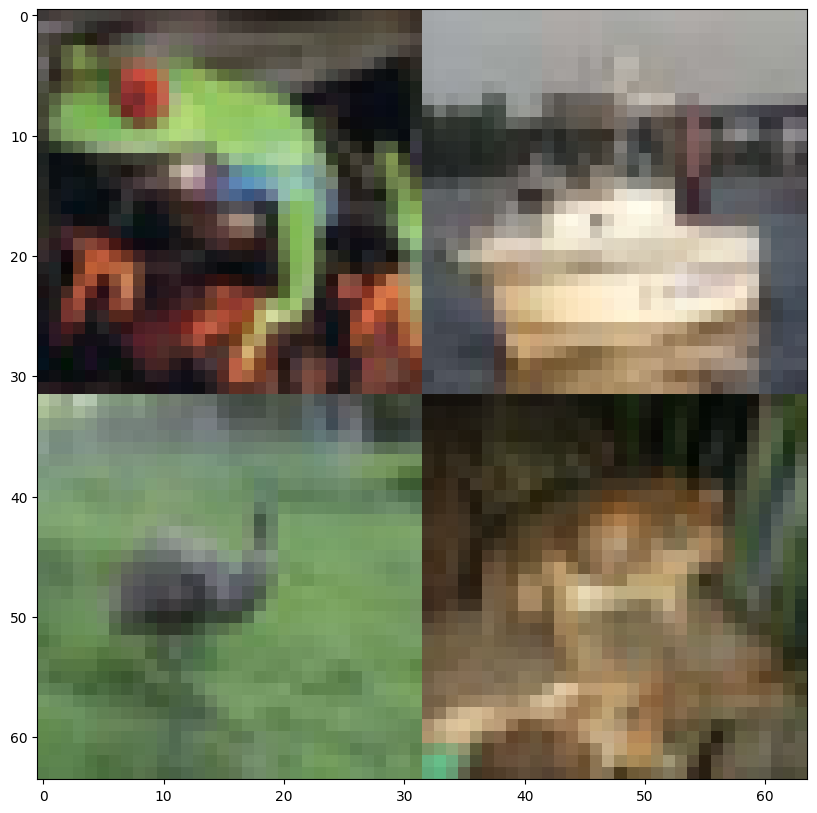

In [84]:
plt.figure(figsize=(10, 10))
plt.imshow(to_image(big_image))
plt.show()

In [78]:
train_set[0][rand_inds[j*5+i]].shape

torch.Size([3, 32, 32])

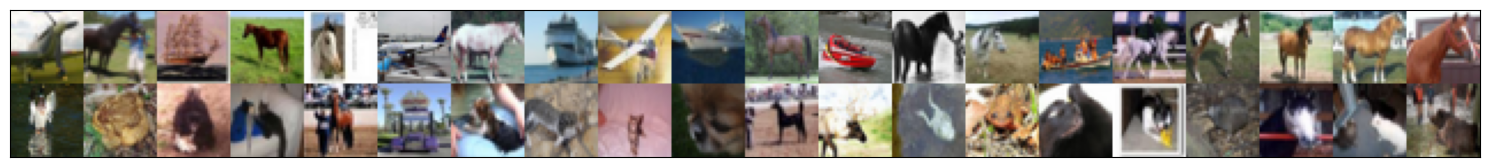

In [104]:
num_samples = 20
normal_inds = np.random.choice(inds[:10000], num_samples)
outlier_inds = inds[-num_samples:]

big_image = []
for j in range(num_samples):
    big_image_row = []
    big_image_row.append(train_set[0][normal_inds[j]])
    big_image_row.append(train_set[0][outlier_inds[j]])
    big_image.append(torch.concat(big_image_row, axis=1))
big_image = torch.concat(big_image, axis=2)

plt.figure(figsize=(15, 2))
plt.imshow(to_image(big_image))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig('cifar10n_normal_vs_outlier.png')

<Figure size 1000x1000 with 0 Axes>

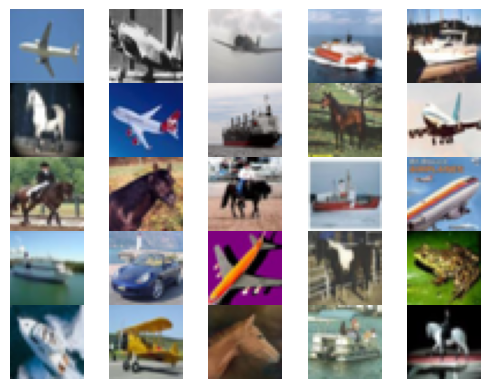

In [59]:
num_samples = 50
rand_inds = np.random.choice(inds[:10000], num_samples)
# rand_inds = inds[:num_samples]
# rand_inds = inds[:num_samples]
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(5, 5, frameon=False)
plt.subplots_adjust(hspace=0, wspace=0)
for j in range(5):
    for i in range(5):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
        axs[j, i].imshow(to_image(train_set[0][rand_inds[j*5+i]]))
        
# fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)

# plt.tight_layout()
plt.show()
# plt.savefig('test_image.png')

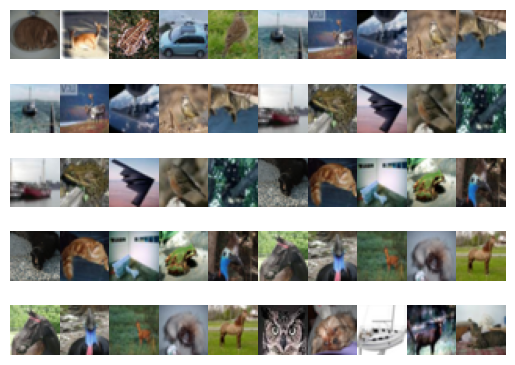

In [23]:
num_samples = 50
# rand_inds = np.random.choice(inds, num_samples)
rand_inds = inds[-num_samples:]
fig, axs = plt.subplots(5, 10, dpi=100)
for j in range(5):
    for i in range(10):
        axs[j, i].imshow(to_image(train_set[0][rand_inds[j*5+i]]))
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
np.random.choice